# Assignment 3
_Due: Midnight on Tuesday October 8, 2019_

### NetID: sa857

In this assignment you will gain some experience with decision trees and random forests using two data sets. One is a diabetes data set, where the task is to predict the progression of the disease. The other a data set of real estate listings, where the task is to forecast the sale price of the house.

#### Submission Instructions:

Please fill out this _starter_ Jupyter Notebook, and submit __both__ this `.ipynb` file as well as a pdf file (via html).

 - In the notebook interface, choose `File -> Download as -> Notebook (ipynb)`.
 - In the notebook interface, choose `File -> Download as -> HTML`. Then open the html file, and print to pdf.

Notes:

 - We are using the markdown cell-type for texts (and latex), and the code cell-type for the python code. Make sure you don't mix these up. You can change the type from the dropdown at the toolbar on the top.
 

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import ipdb
import pprint

## Question 1: Regression trees vs. random forests (20 pts)

This problem is based on the `diabetes` dataset from the `sklearn` package. Please read about the dataset at [https://scikit-learn.org/stable/datasets/index.html#diabetes-dataset](https://scikit-learn.org/stable/datasets/index.html#diabetes-dataset). We will seek to predict the response, which is a quantitative measure of diabetes progression one year after baseline, using regression trees and random forests.

The following cell imports the dataset as `diabetes` and names the predictor variables `diabetes_x` and the response `diabetes_y`. The names of the six predictor variables are also printed. For a more detailed description, use the `.DESCR` aspect of `diabetes`.

In [99]:
from sklearn import datasets
diabetes = datasets.load_diabetes()
diabetes_x = diabetes.data
diabetes_y = diabetes.target
print(diabetes.feature_names)


['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


### Part (a): Building a Simple Regression Tree

To start we will manually build a regression tree using only two of the predictor variables: `bmi` and `s5`. To keep things simple, build a tree that has exactly three nodes and four leaves. (i.e. the data is split into two parts initially and then each of those parts is again split one more time.) At each node you will need to evaluate each possible splitting point for both `bmi` and `s5` and pick the one that minimizes the RSS.

When you have built the regression tree, create a scatter plot of `s5` versus `bmi`, color-coded by the response variable. In this plot, use vertical and horizontal lines to indicate the regions that your tree splits the data into. You may find the functions `plt.hlines()` and `plt.vlines()` to be useful.

In [100]:
bmi = diabetes_x[:,2] # all rows in the bmi column
s5 = diabetes_x[:,8]  # all rows in the s5  column

In [101]:
# we put a wrapper on the np.mean function to avoid warnings from taking the average of an empty list
def average(x):
    if len(x) == 0:
        return(0.0)
    else:
        return(np.mean(x))

In [102]:
def splitter(bmi_dat, s5_dat, labels_dat):
        
    rss_bmi = []
    rss_s5 = []
    
    
    for i in range(len(bmi_dat)): # go through all the rows
        
        # for bmi (body mass index)
        left = np.where(bmi_dat <= bmi_dat[i])[0] # all entries' indices such that entries <= current val
        right = np.where(bmi_dat > bmi_dat[i])[0] # all entries' indices such that entries > current val

        # actually the TSS: actual value - average 
        # how good is this partition?
        # this is done by using the indices from the previous steps
        rss_bmi.append(np.sum((labels_dat[left] - average(labels_dat[left]))**2) + 
                       np.sum((labels_dat[right] - average(labels_dat[right]))**2))
        
        # do the same for s5
        left = np.where(s5_dat <= s5_dat[i])[0]
        right = np.where(s5_dat > s5_dat[i])[0]
        
        # how good is this partition?
        rss_s5.append(np.sum((labels_dat[left] - average(labels_dat[left]))**2) + 
                      np.sum((labels_dat[right] - average(labels_dat[right]))**2))
        
    # return the indices of rss arrays which produced the best splits (lowest RSS)
    return {
        "best_bmi_cut" : np.argmin(rss_bmi),
        "best_s5_cut" : np.argmin(rss_s5),
        "best_bmi_cut_rss" : rss_bmi[np.argmin(rss_bmi)],
        "best_s5_cut_rss" : rss_s5[np.argmin(rss_s5)]
    }


In [103]:
def createNewDataFromSplit(bmi_dat, s5_dat, labels_dat, split_dat):
    
    # figure out best cut and indices between the two predictors
    if split_dat["best_s5_cut_rss"] < split_dat["best_bmi_cut_rss"]:
        best_overall_cut = split_dat["best_s5_cut"]
        best_overall_cut_location = s5_dat[best_overall_cut]
        best_overall_cut_type = "s5"
        which_indices_left = np.where(s5_dat <= s5_dat[best_overall_cut])
        which_indices_right = np.where(s5_dat > s5_dat[best_overall_cut])
    else:
        best_overall_cut = split_dat["best_bmi_cut"]
        best_overall_cut_location = bmi_dat[best_overall_cut]
        best_overall_cut_type = "bmi"
        which_indices_left = np.where(bmi_dat <= bmi_dat[best_overall_cut])
        which_indices_right = np.where(bmi_dat > bmi_dat[best_overall_cut])
    
    # left partition
    s5_left = s5_dat[which_indices_left]
    bmi_left = bmi_dat[which_indices_left]
    labels_left = labels_dat[which_indices_left]

    # right partition
    s5_right = s5_dat[which_indices_right]
    bmi_right = bmi_dat[which_indices_right]
    labels_right = labels_dat[which_indices_right]
    
    # tests
    assert(len(s5_left) + len(s5_right) == len(s5_dat))
    assert(len(bmi_left) + len(bmi_right) == len(bmi_dat))
    assert(len(labels_left) + len(labels_right) == len(labels_dat))
    assert(len(s5_left) == len(bmi_left))
    assert(len(s5_right) == len(bmi_right))

    # return all data
    return {
        "s5_left" : s5_left,
        "bmi_left" : bmi_left,
        "labels_left" : labels_left,
        
        "s5_left_len" : len(s5_left),
        "bmi_left_len" : len(bmi_left),
        "labels_left_len" : len(labels_left),

        "s5_right" : s5_right,
        "bmi_right" : bmi_right,
        "labels_right" : labels_right,
        
        "s5_right_len" : len(s5_right),
        "bmi_right_len" : len(bmi_right),
        "labels_right_len" : len(labels_right),
        
        "best_overall_cut" : best_overall_cut,
        "best_overall_cut_type" : best_overall_cut_type,
        "best_overall_cut_location" : best_overall_cut_location,
        "which_indices_left" : which_indices_left,
        "which_indices_right" : which_indices_right,
    }
        
   

In [104]:
def splitPipeline(bmi_dat, s5_dat, labels_dat):
    split_results = splitter(bmi_dat, s5_dat, labels_dat)
    new_dat = createNewDataFromSplit(bmi_dat, s5_dat, labels_dat, split_results)
    return new_dat

In [105]:
# first split
first_split_dat = splitPipeline(bmi, s5, diabetes_y)

In [106]:
# left split
left_split_dat = splitPipeline(first_split_dat["bmi_left"], 
                               first_split_dat["s5_left"], 
                               first_split_dat["labels_left"])

left_leaf_one = {
    "bmi": left_split_dat["bmi_left"], 
    "s5": left_split_dat["s5_left"],
    "labels" : left_split_dat["labels_left"]
}

left_leaf_two = {
    "bmi": left_split_dat["bmi_right"], 
    "s5": left_split_dat["s5_right"],
    "labels" : left_split_dat["labels_right"]
}

In [107]:
# RIGHT NODE
right_split_dat = splitPipeline(first_split_dat["bmi_right"], 
                               first_split_dat["s5_right"], 
                               first_split_dat["labels_right"])

right_leaf_one = {
    "s5": right_split_dat["s5_left"],
    "bmi": right_split_dat["bmi_left"], 
    "labels": right_split_dat["labels_left"]
}

right_leaf_two = {
    "s5": right_split_dat["s5_right"],
    "bmi": right_split_dat["bmi_right"], 
    "labels" :right_split_dat["labels_right"]
}

In [108]:
# You should feel free to rewrite the above code in any way that suits you.
# Now complete the code to make the best split, and then split each child node, 
# and then visualize the tree, showing the four leaf rectangles in the space s5 vs. bmi

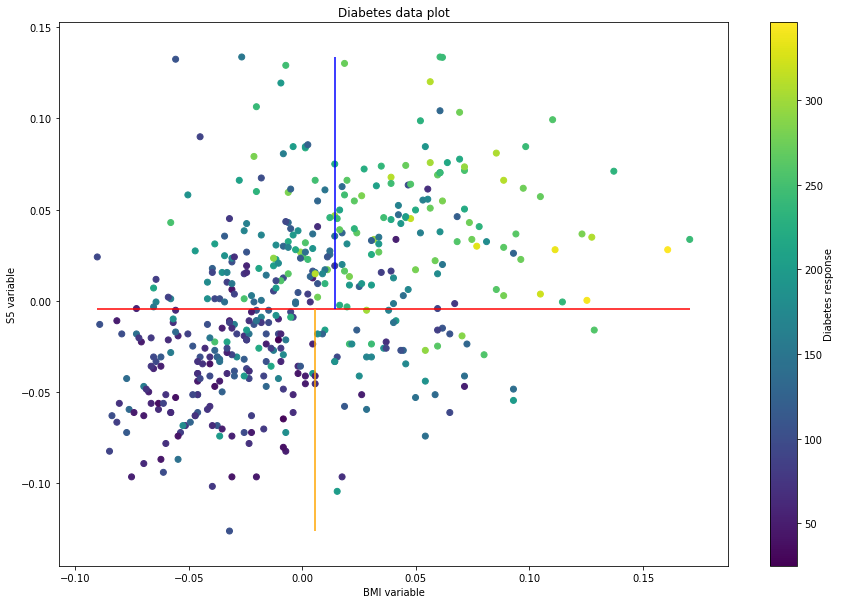

In [136]:
# draw the main figure
plt.figure(figsize=(15,10))
plt.scatter(bmi, s5, c=diabetes_y)
plt.title("Diabetes data plot")
plt.xlabel("BMI variable")
plt.ylabel("S5 variable")
cbar = plt.colorbar()
cbar.set_label("Diabetes response", labelpad=+1)

# draw the cuts

# the first one was an s5 cut at -0.00421985970694603
plt.hlines(y=first_split_dat["best_overall_cut_location"], 
           xmin=min(bmi), 
           xmax=max(bmi), 
           label="Split 1",
           color="red")

# the second one was a bmi cut at 0.00564997867688165
plt.vlines(left_split_dat["best_overall_cut_location"], 
           min(s5), 
           first_split_dat["best_overall_cut_location"], 
           label="Split 2",
           color="orange")

# the third one was a bmi cut at 0142724752679289
plt.vlines(right_split_dat["best_overall_cut_location"], 
           first_split_dat["best_overall_cut_location"], 
           max(s5), 
           label="Split 3", 
           color="blue")


In [126]:
# start adding cuts
pprint.pprint(right_split_dat)

{'best_overall_cut': 17,
 'best_overall_cut_location': 0.0142724752679289,
 'best_overall_cut_type': 'bmi',
 'bmi_left': array([-0.01159501, -0.00189471, -0.01806189,  0.01211685, -0.01267283,
       -0.02129532, -0.00620595, -0.03099563,  0.01103904,  0.01427248,
       -0.00836158,  0.01427248, -0.06440781, -0.02560657,  0.00457217,
       -0.02452876, -0.01806189, -0.00405033,  0.00241654, -0.03099563,
       -0.05794093,  0.01211685, -0.00620595,  0.00457217, -0.05794093,
        0.00996123, -0.06440781,  0.01427248,  0.00133873, -0.02129532,
       -0.0105172 , -0.04716281, -0.00836158, -0.00189471,  0.01211685,
       -0.00512814, -0.00081689, -0.03315126, -0.0191397 , -0.02668438,
        0.00996123, -0.01590626,  0.00457217,  0.00564998, -0.03530688,
       -0.01806189, -0.00297252, -0.01267283, -0.04177375, -0.00512814,
       -0.05901875,  0.00349435, -0.04500719,  0.00133873,  0.00672779,
        0.00349435, -0.06548562, -0.04177375, -0.03854032, -0.02560657,
       -0.03099

### Part (b) Fitting a Full Regression Tree

Now build a tree that uses all the predictor variables, has a more flexible structure, and is validated with a test set. Split the full dataset into a training set and a test set (50/50). Fit a regression tree to the training set using the function `DecisionTreeRegressor` from `sklearn.tree`. For now, use your best judgment to choose parameters for tree complexity; we will use analytical methods to choose parameters in later parts of this problem set. Some starter code is provided:

In [ ]:
from sklearn import tree

regr = tree.DecisionTreeRegressor().fit() #tree parameters go inside the first set of parenthases and the training data
                                          #goes in the second set of parenthases

### Part (c) Plotting the Tree

Plot your regression tree. To do so, we suggest that you use GraphViz in conjunction with `sklearn.tree.export_graphviz`. Once you install GraphViz, the following cell will plot the tree.

Instructions for using GraphViz (Windows):

1. Install GraphViz to your computer from the link [https://graphviz.gitlab.io/download/](https://graphviz.gitlab.io/download/).

2. Install the Python package using `pip install graphviz` or `conda install graphviz`.

3. Set a path to your computer's GraphViz installation (NOT the Python package). You can do so locally in this notebook by running something like `import os; os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'` (substituting in the location of your own GraphViz installation).

4. You can now use the functions in the `graphviz` package with `sklearn.tree.export_graphviz`!

Instructions for using GraphViz (Mac OS):

1. Make sure you have the package manager Homebrew.

2. Install GraphViz to your computer using `brew install graphviz`.

3. Install the Python package using `pip install graphviz` or `conda install graphviz`.

4. You can now use the functions in the `graphviz` package with `sklearn.tree.export_graphviz`! _Note: If you get an ExecutableNotFound error, you might have to set a path to your computer's GraphViz installation (NOT the Python package). You can do so locally in this notebook by running something like `import os; os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'` (substituting in the location of your own GraphViz installation)._


In [ ]:
import graphviz
#import os; os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

graphviz.Source(tree.export_graphviz(regr, out_file=None, feature_names=dat.feature_names))

### Part (d) Evaluation

Interpret your regression tree. What are some examples of variables that seem to correspond with higher or lower measures of diabetes progression? Find the MSE of the model using the test set. The `.predict` method for your model can help with this.

In [ ]:
# Your Code Here

### Part (e) Random Forest

Now use random forests to analyze the data with the `RandomForestRegressor` function from `sklearn.ensemble`. (Again, you may use your best judgment to choose the initial parameters for tree complexity.)

__(i)__ What test MSE do you obtain, and how does it compare to the test MSE of the regression tree above? 

__(ii)__ According to the model, which variables are most important in predicting diabetes progression? (The `.feature_importances_` method of the model may help with this.)

__(iii)__ Plot the MSE of the prediction against $m$, the number of variables considered at each split.

__(iv)__ Comment on the plot you created and if it makes sense.

In [ ]:
from sklearn import ensemble

# Here is an example of how to use the random forest function in sklearn.ensemble.
# The code below assumes that the training inputs and responses are loaded in the variables train_x and train_y
# and that the test predictor variables are in test_x

# dtr = ensemble.RandomForestRegressor(min_samples_leaf = 15, max_features = m)
# regr = dtr.fit(train_x, train_y)
# pred_y = regr.predict(test_x)
# mse = sum(np.square(test_y-pred_y))

# Your Code Here

## Question 2: Analyzing Real Estate Data (40 pts)

In this problem, you will train random forests on data from the website Zillow to forecast the sale price of real estate listings. Random forests are nonparametric methods for classification and regression. As discussed in class, the method is based on the following idea: a good predictor will have low bias and low variance. A deep decision tree has low bias, but high variance. To reduce the variance, multiple trees are fit and averaged together. By introducing randomness in the construction of the trees, the correlation between them is reduced, to facilitate the variance reduction.

Read in the training and test sets as follows:

`import pandas as pd
train = pd.read_csv("zillow_train.csv")
test = pd.read_csv("zillow_test.csv")`

Use the following variables: `Lat`, `Long`, `ListPrice`, `SaleYear`, `Bathroom`, `Bedroom`, `BuildDecade`, `MajorRenov`, `FinishSqFt`, `LotSqFt`, `MSA`, `City`, `HighSchool`, `SalePrice`. You will build regression models to predict `SalePrice`.


### (a) Explore the data

Get an idea of what kind of data you're working with. As usual, you might ask yourself what $n$ (sample size) and $p$ (number of predictor variables) are here. Make plots of the distributions of the variables. Include a plot of the response, `SalePrice`. Does it appear that the data are "raw", or have they been pre-processed in different ways? If so, how?

In [ ]:
# Your Code Here

`Comment here on the above questions`

### Part (b) Preliminary steps

__(i)__ Some of the variables in the data are categorical; how many values do they take? (You may find the `.nunique` method of pandas to be useful here.) Why might factor variables with many categories present a problem when fitting decision trees? Describe a couple different ways of handling factor variables when fitting decision trees.


`Your Markdown Here`

__(ii)__ Use your best judgement to modify the Zillow dataset to handle factor variables. In addition to `pandas` and `numpy`, it might be helpful to look at functions in `sklearn.preprocessing`.

In [ ]:
# Your Code Here

__(iii)__ We will soon use a few methods to predict `SalePrice`. Throughout, we will evaluate the predictions in terms of the absolute relative error:

<center>$\frac{1}{n}\sum_{i=1}^n \frac{\mid Y_i - \hat{Y}_i\mid}{Y_i}$</center>

Explain why this is a more appropriate choice of accuracy, compared with squared error.

`Your Markdown Here`

### Part (c) Build models using random forests

Build random forest models to predict `SalePrice` from the other variables, using the appropriate method from `sklearn.ensemble`. As in Question 1, one parameter to vary is `max_features`, or the number of variables allowed in each split; this regulates the correlation between the trees in the random forest by introducing randomness. Two more relevant parameters are `n_estimators` and `min_samples_leaf`, or number of trees and minimum node size, which regulate variance and bias.

Train several random forest models, each time using different values of the parameters. Evaluate each model using 5-fold cross-validation (`sklearn.model_selection.KFold` may be a useful resource to perform k-fold cross-validation). For the sake of time, you may keep `n_estimators` low and constant. First vary `max_features` and create a plot of the cross-validation error versus the value of this parameter. Next vary `min_samples_leaf` a create a similar plot with the values of this parameter. 

Comment on how cross-validation error relates to `max_features` and `min_samples_leaf`, and how do you imagine it would relate to `n_estimators`? Does this make sense to you?

Now find a combination of values for `max_features` and `min_samples_leaf` that approximately minimizes the cross-validation error. 

_Note: Use mean absolute error (`mae`) rather than mean squared error (`mse`) as the criterion for growing the trees. But then when you evaluate different models, compute the relative absolute error, as described above._

In [ ]:
#Starter Code to fill in and complete
from sklearn import model_selection
kf = model_selection.KFold(n_splits=5)

x = 
y = 

for m in range( , ): # vary min_samples_leaf

    dtr = ensemble.RandomForestRegressor(n_estimators = 15, min_samples_leaf = m, #these are the parameters to vary
                                         max_features = 10, criterion = 'mae')
    
    for train_index, test_index in kf.split(x):
        train_x = 
        train_y = 
        regr = dtr.fit(train_x, train_y)
        

### Part (d) Comparison to Least-Squares Regression

Now build a least-squares linear model for the response variable as a function of the predictor variables using the training set. You may wish to use the `sklearn.linear_model.LinearRegression` function, described
[here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

Experiment with different subsets of the predictor variables included in the linear model. 

Using the random forest model from Part (c) with the best combination of values for `max_features` and `min_samples_leaf` that you found, compare both the mean squared error and the relative absolute error on the test set from the random forest and linear models.

Which model does a better job at prediction? Do you think the model with the higher MSE has higher variance or higher bias, or both?

In [ ]:
#Your Code Here

`Your Markdown Here`

### Part (e) Predicting SalePrice

Read in the file "zillow_part_e.csv" which has 7000 houses with all the same variables as the training and testing set, except that the SalePrice variable is missing. 

Construct the best model you can on the training data. You can use random forests, or you may try to use gradient tree boosting, which is also available in sklearn.ensemble.  

Using your best model, predict the sale prices for these 7000 houses. Students will be assigned extra credit according to which decile they are in for the predictive accuracy (relative absolute error). (The top 10% will receive 10 points extra credit, the next 10% 9 points, and so on.) 

Save your predictions in a file called "zillow_predictions.csv" and submit this file with your homework. Your csv file should only contain a single column of predictions, without a header, where the $i$-th row corresponds to the predicted sale price for the $i$-th row of the dataset read in from "zillow_part_e.csv", excluding the header.


In [ ]:
# Your Code Here
newdata = pd.read_csv("zillow_part_e.csv")
